In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.core.reshape.merge import merge
from pandas.io.pytables import Fixed
import pymrio
import scipy.io
from matplotlib import colors as mcolors, rc_params
import seaborn as sns
import os
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.markers as mmark
import matplotlib.lines as mlines
from scipy import stats
import country_converter as coco
import matplotlib as mpl
import geopandas
from matplotlib.patches import ConnectionPatch
from matplotlib.cm import ScalarMappable
import matplotlib as mpl
cc = coco.CountryConverter(include_obsolete=True)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from geopandas import GeoDataFrame
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [44]:
def plt_rcParams():
    fsize = 10
    tsize = 10
    tdir = "out"
    major = 5.0
    minor = 3.0
    lwidth = 0.8
    lhandle = 2.0
    plt.style.use("default")
    plt.rcParams["text.usetex"] = True
    plt.rcParams["font.size"] = fsize
    plt.rcParams["legend.fontsize"] = tsize
    plt.rcParams["xtick.direction"] = tdir
    plt.rcParams["ytick.direction"] = tdir
    plt.rcParams["xtick.major.size"] = major
    plt.rcParams["xtick.minor.size"] = minor
    plt.rcParams["ytick.major.size"] = 3.0
    plt.rcParams["ytick.minor.size"] = 1.0
    plt.rcParams["axes.linewidth"] = lwidth
    plt.rcParams["legend.handlelength"] = lhandle
    plt.rcParams["figure.facecolor"] = "white"
    plt.rcParams["axes.axisbelow"] = True
    return None

plt_rcParams()

In [12]:
world_filepath = geopandas.datasets.get_path('naturalearth_lowres')
world = geopandas.read_file(world_filepath)
print(world[world['name'] == 'Antarctica'])
world = world.drop(world.index[159])
print(world[world['name'] == 'Fr. S. Antarctic Lands'])

world = world.drop(world.index[23])
gdf=world[['name','geometry']]
gdf['region'] = cc.convert(names = gdf['name'], to = 'EXIO3')
gdf['region'].loc[176]='WF'
gdf = gdf.drop('name',axis=1)

S. Sudan not found in regex


     pop_est   continent        name iso_a3  gdp_md_est  \
159     4050  Antarctica  Antarctica    ATA       810.0   

                                              geometry  
159  MULTIPOLYGON (((-48.66062 -78.04702, -48.15140...  
    pop_est                continent                    name iso_a3  \
23      140  Seven seas (open ocean)  Fr. S. Antarctic Lands    ATF   

    gdp_md_est                                           geometry  
23        16.0  POLYGON ((68.93500 -48.62500, 69.58000 -48.940...  


C:\Users\andrieba\anaconda3\envs\my_env\lib\site-packages\geopandas\geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\andrieba\anaconda3\envs\my_env\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [13]:
# define top and bottom colormaps 
bottom = cm.get_cmap('Oranges', 128) # r means reversed version
top = cm.get_cmap('Blues_r', 128)
# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
# create a new colormaps with a name of OrangeBlue
orange_blue = ListedColormap(newcolors, name='OrangeBlue')

class MidpointNormalize(mpl.colors.Normalize):
    """
    class to help renormalize the color scale
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    

elev_min = 0
elev_max = 100
mid_val = 50

norm = MidpointNormalize(midpoint=mid_val,vmin=elev_min,vmax=elev_max)

In [14]:
imports_sat2016 = pd.read_csv('imports_sat2016.csv',index_col=[2,1,0])
imports_imp2016 = pd.read_csv('imports_imp2016.csv',index_col=[2,1,0])

In [15]:
imports = pd.concat([imports_sat2016.loc["Domestic Extraction Used - Fossil Fuel: Total"]['2016'],
          imports_imp2016.loc["Domestic Extraction Used - Non-metalic Minerals"]['2016'],
          imports_imp2016.loc[["Domestic Extraction Used - Iron Ore","Domestic Extraction Used - Non-ferous metal ores"]].groupby(level=[1,2]).sum()['2016']],
          keys=['Fossil fuels','Non-metalic minerals','Metal ores'],axis=1)

In [16]:
share = pd.DataFrame([],columns=imports.columns,index=imports.unstack().index)
for ext in imports.columns:
    for reg in imports.unstack().index:
        share[ext].loc[reg] = 1-imports[ext].loc[reg].loc[reg]/imports[ext].loc[reg].sum()

C:\Users\andrieba\AppData\Local\Temp/ipykernel_3984/1215847252.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[j,i].set_xticklabels([dict_names[i] for i in share[sect].sort_values().index], rotation=90,fontsize=5)
C:\Users\andrieba\AppData\Local\Temp/ipykernel_3984/1215847252.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[j,i].set_xticklabels([dict_names[i] for i in share[sect].sort_values().index], rotation=90,fontsize=5)
C:\Users\andrieba\AppData\Local\Temp/ipykernel_3984/1215847252.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[j,i].set_xticklabels([dict_names[i] for i in share[sect].sort_values().index], rotation=90,fontsize=5)


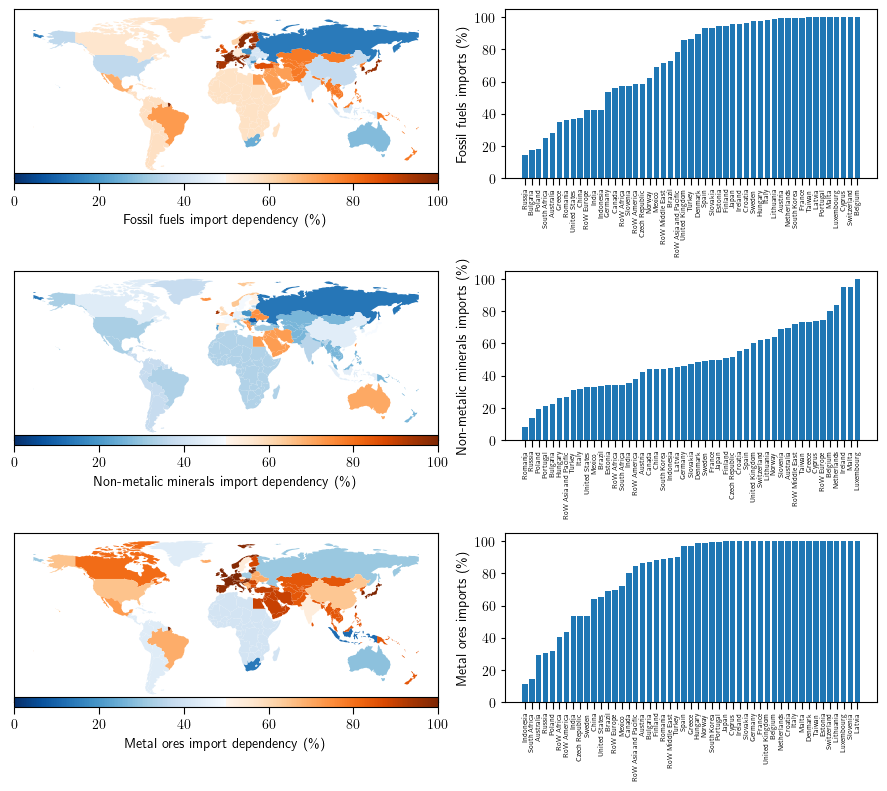

In [62]:
gdf12 = gdf.set_index('region')
for col in share.columns:
    gdf12[col]=pd.DataFrame(share.astype(float),index=gdf['region'])[col]*100

sectors = share.columns.values
titles = share.columns.values

fix, ax = plt.subplots(3,2, gridspec_kw={'width_ratios': [1.5, 1]}, figsize=(12,9))
plt.subplots_adjust(wspace=0, hspace=0.55)

pos = [2, 3.2, 2, 3.3, 7, 20, 20, 2.5, 7, 1.7, 4, 3.5]
eps = [0,0,0]

names = pd.read_excel("region names.xlsx", index_col=None)
dict_names = dict(zip(names["region"], names["full name"]))

col = pd.read_excel("continent.xlsx", index_col=[0])
cmap = sns.color_palette("colorblind", as_cmap="True")
dict_color = dict(
        zip(col["continent"].unique(), cmap[0 : len(col["continent"].unique())])
    )
col["color"] = col["continent"].replace(dict_color)

for j in range(0,3,1):
    i=0    
    sect=sectors[j]
    
    divider = make_axes_locatable(ax[j,i])
    #cax = divider.append_axes("bottom",size="7%",pad="0%")
    cax =inset_axes(ax[j,i],
                   width="100%",  # width = 5% of parent_bbox width
                   height="6%",  # height : 50%
                   loc='lower center',
                   bbox_to_anchor=(0, -.03, 1, 1),
                   bbox_transform=ax[j,i].transAxes,
                   borderpad=0,
                   )
    ax[j,i].set_xticks([])
    ax[j,i].set_yticks([])
    #ax[j,i].set_title(titles[j],loc='left',y=1.01)
    gdf12.plot(column=sect,ax=ax[j,i],cmap=orange_blue,legend=True,legend_kwds={'label': sect +' import dependency (\%)','orientation': "horizontal"},norm=norm,cax=cax)
    
    i=1
    #ax[j,i].hist(share[sect]*100,bins=20,grid=True)
    #ax[j,i].set_xlim([0,101])
    ax[j,i].set_ylabel(sect +' imports (\%)')
    ax[j,i].bar(share[sect].sort_values().index,share[sect].sort_values()*100)
    #color = [col['color'].loc[i] for i in share[sect].sort_values().index]
    ax[j,i].set_xticklabels([dict_names[i] for i in share[sect].sort_values().index], rotation=90,fontsize=5)
    #ax[j,i].set_xticks(['FR'], rotation=45)

plt.savefig('figures/figure5.pdf', bbox_inches = 'tight', facecolor='w')
plt.savefig('figures/figure5.svg', bbox_inches = 'tight', facecolor='w')
plt.savefig('figures/figure5.png', bbox_inches = 'tight', facecolor='w')

In [56]:
col = pd.read_excel("continent.xlsx", index_col=[0])
cmap = sns.color_palette("colorblind", as_cmap="True")
dict_color = dict(
        zip(col["continent"].unique(), cmap[0 : len(col["continent"].unique())])
    )
col["color"] = col["continent"].replace(dict_color)

In [57]:
col

,continent,color
EXIO3,,
AT,Europe,#0173B2
AU,Australia,#DE8F05
BE,Europe,#0173B2
BG,Europe,#0173B2
BR,Latin America,#029E73
CA,USA and Canada,#D55E00
CH,Europe,#0173B2
CN,China,#CC78BC
CY,Rest of Asia,#CA9161


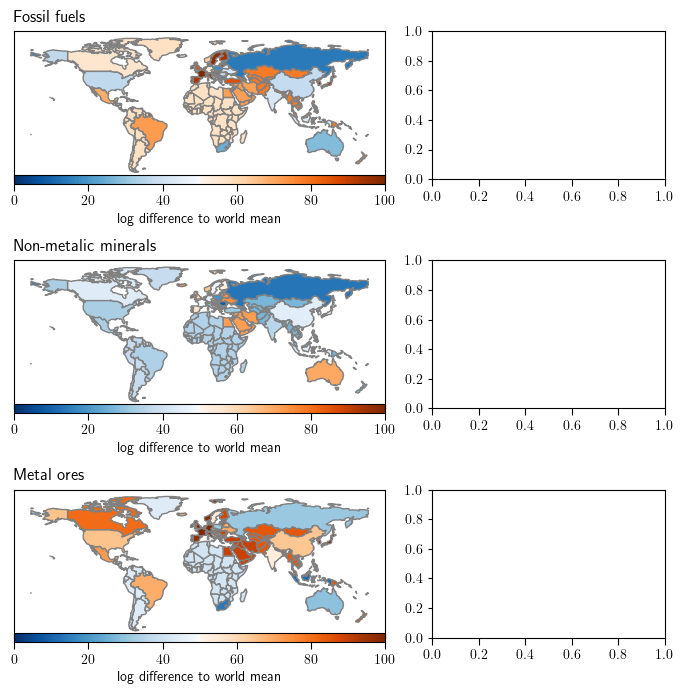

In [18]:
gdf12 = gdf.set_index('region')
for col in share.columns:
    gdf12[col]=pd.DataFrame(share.astype(float),index=gdf['region'])[col]*100

sectors = share.columns.values
titles = share.columns.values

fix, ax = plt.subplots(3,2, gridspec_kw={'width_ratios': [2, 1]}, figsize=(9,10.5*3/4))
plt.subplots_adjust(wspace=0, hspace=0.55)

pos = [2, 3.2, 2, 3.3, 7, 20, 20, 2.5, 7, 1.7, 4, 3.5]
eps = [0,0,0]


for j in range(0,3,1):
    i=0    
    sect=sectors[j]
    
    divider = make_axes_locatable(ax[j,i])
    #cax = divider.append_axes("bottom",size="7%",pad="0%")
    cax =inset_axes(ax[j,i],
                   width="100%",  # width = 5% of parent_bbox width
                   height="6%",  # height : 50%
                   loc='lower center',
                   bbox_to_anchor=(0, -.03, 1, 1),
                   bbox_transform=ax[j,i].transAxes,
                   borderpad=0,
                   )
    ax[j,i].set_xticks([])
    ax[j,i].set_yticks([])
    ax[j,i].set_title(titles[j],loc='left',y=1.01)
    gdf12.plot(column=sect,edgecolor='gray',ax=ax[j,i],cmap=orange_blue,legend=True,legend_kwds={'label': 'log difference to world mean','orientation': "horizontal"},norm=norm,cax=cax)
    


